# Testing EOF decomposition with dask using `xeofs` package

**Similar code to `eof_ersst.ipynb` but replacing Numpy functions with Xarray functions**

In progress work using the `xeofs` package to analyze multi-decadal SST variability on a local machine. Data are accessed using `earthaccess` package.

Ultimately want to perform an analysis such as: https://doi.org/10.1175/2011JCLI3941.1 

Which uses the dataset: https://podaac.jpl.nasa.gov/dataset/REYNOLDS_NCDC_L4_MONTHLY_V5

Thise notebook is meant to be run as a Coiled Notebook, see docs here: https://docs.coiled.io/user_guide/usage/notebooks/index.html#notebook-file-sync 

Additional reference used for EOF analysis: https://github.com/royalosyin/Python-Practical-Application-on-Climate-Variability-Studies/blob/master/ex18-EOF%20analysis%20global%20SST.ipynb

Because the time variable in this dataset is non-conventional, the `cftime` package is required to decode the timestamps using `Xarray`.

Although the above study uses the time period 1910 to 2009, we instead use 1910 to 2008, since the data providers of the dataset changed the time format from 2008 onward and xarray doesn't like it.

Github issue with valuable information on scaling the output from the xeofs package in different ways (for example the initial xeofs output does not match the scale of the publication): https://github.com/nicrie/xeofs/issues/81 

In [1]:
## Need latest versions (as of October 2023) of all the below packages to ensure this notebook works

import earthaccess

import xarray as xr
import numpy as np
import xeofs as xe
from eofs.standard import Eof

import matplotlib.pyplot as plt
from cartopy.crs import EqualEarth, PlateCarree

import coiled

%matplotlib inline

# 1. Locate file endpoints and load data with `Xarray`

## 1.1 Locate endpoints
The `earthaccess` package is used to login to Earthdata and locate endpoints for all needed data files. The endpoints will be used with `Xarray` to access the data without downloading.

In [126]:
earthaccess.login() # Login with your credentials

We are already authenticated with NASA EDL


In [127]:
%%time

# Locate endpoints:
endpoints = earthaccess.search_data(
    short_name="REYNOLDS_NCDC_L4_MONTHLY_V5",
    cloud_hosted=True,
    temporal=("1910-01-01", "2008-02-01"), # We only want till end of 2007, but this ending date was required to obtain that.
    )

Granules found: 1178
CPU times: user 154 ms, sys: 3.25 ms, total: 157 ms
Wall time: 21.1 s


In [128]:
# Generate file objects from the endpoints which are compatible with Xarray:
fileobjs = earthaccess.open(endpoints[1:]) # The month prior to 1910-01-01 is included in the returned endpoints (bug?), so start the list at the 2nd element.

 Opening 1177 granules, approx size: 0.12 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | : 0it [00:00, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1177 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1177 [00:00<?, ?it/s]

**Removal of one of the file objects which returned a bad result**

These lines of code are not typically needed for other datasets, but for some reason earthaccess returns one endpoint for a file which does not exist. Remove this element from the file objects list:

In [129]:
# Print the bad result just for reference:
fileobjs_bad = [f for f in fileobjs if type(f) == FileNotFoundError]
print(fileobjs_bad)

# Remove this bad result from the list:
fileobjs = [f for f in fileobjs if type(f) != FileNotFoundError]

[FileNotFoundError('podaac-ops-cumulus-protected/REYNOLDS_NCDC_L4_MONTHLY_V5/ersst.v5.195908.nc.1')]


## 1.2 Load data

If working in the cloud, loading and combining all files for this analysis into a single dataset object will take 2-4 minutes. This can be sped up using e.g. `kerchunk` or parallelization with remote clusters, but to simplify this notebook those methods are not implemented.

In [130]:
%%time

# The runtime of this line can be decreased using parallelization:
sstdata = xr.open_mfdataset(fileobjs, chunks={})
sstdata = sstdata.squeeze() # Remove the unnecessary 'lev' dimension (size 1)
sstdata

CPU times: user 38.1 s, sys: 306 ms, total: 38.4 s
Wall time: 3min 10s


<xarray.Dataset>
Dimensions:  (lat: 89, lon: 180, time: 1176)
Coordinates:
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
    lev      float64 0.0
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) object 1910-01-01 00:00:00 ... 2007-12-01 00:00:00
Data variables:
    sst      (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
    ssta     (time, lat, lon) float32 dask.array<chunksize=(1, 89, 180), meta=np.ndarray>
Attributes: (12/38)
    Conventions:                CF-1.6, ACDD-1.3
    metadata_link:              https://doi.org/10.7289/V5T72FNM
    id:                         ersst.v5.191001
    naming_authority:           gov.noaa.ncei
    title:                      NOAA ERSSTv5 (in situ only)
    summary:                    ERSST.v5 is developped based on v4 after revi...
    ...                         ...
    platform:                   Ship and Buoy SSTs from ICOADS R3.0 and NCEP GTS
    instrument:                 Conventional thermometers
    source:                     In situ data: ICOADS R3.0 before 2015, NCEP i...
    comment:                    SSTs were observed by conventional thermomete...
    references:                 Huang et al, 2017: Extended Reconstructed Sea...
    climatology:                Climatology is based on 1971-2000 SST, Xue, Y...

# 2. Detrend and Remove Seasonal Cycle

As in the publication, we remove the long term linear trend and the seasonal cycle from the timeseries, since we are interested in modes of variablility other than these two (otherwise they would show as the first two modes).

**Future updates**
* Try using Xarray's version of Polyfit: https://docs.xarray.dev/en/stable/generated/xarray.Dataset.polyfit.html
* Try using Xarray's groupby to compute mean seasonal cycle: https://docs.xarray.dev/en/stable/generated/xarray.DataArray.groupby.html

In [131]:
# Remove data poleward of 65 degress lat (copying the publication):
sstdata = sstdata.sel(lat=slice(-65, 65))

### 2.1 Linear Detrend

In [133]:
sst_detrend = sstdata['sst']

Compute and remove linear trend

In [134]:
# Nothing actually computed fully in this block:
p = sst_detrend.polyfit(dim='time', deg=1) # Degree 1 polynomial fit coefficients over time for each lat, lon.
fit = xr.polyval(sst_detrend['time'], p.polyfit_coefficients) # Compute linear trend time series at each lat, lon.
sst_detrend = (sst_detrend - fit) # xarray is smart enough to subtract along the time dim only.

Test plot of detrend results at a few locations on the globe

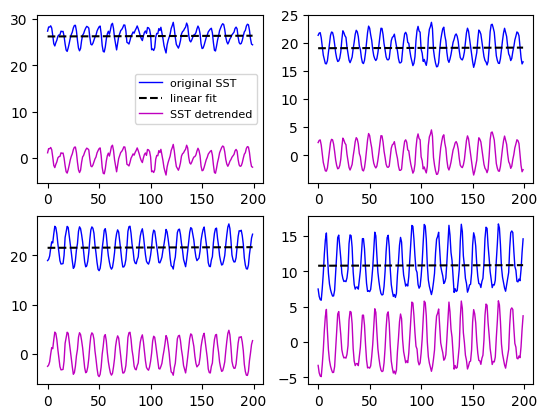

In [135]:
# Need to find lats, lons in the dataset that are closest to a few chosen values.
testpoints = sstdata['sst'].sel(lat=[0, -30, 30, 45], lon=[0, 90, 190, 220], method='nearest')
lat_testpoints = testpoints['lat'].data
lon_testpoints = testpoints['lon'].data


# The way dask arrays work, nothing has been computed yet, so compute SST's (before and after detrending)
# and linear fit for the few testpoints here:
sst_testpoints = sstdata['sst'].sel(lat=lat_testpoints, lon=lon_testpoints).compute() # points before detrend
fit_testpoints = fit.sel(lat=lat_testpoints, lon=lon_testpoints).compute() # linear fit
sst_detrend_testpoints = sst_detrend.sel(lat=lat_testpoints, lon=lon_testpoints).compute() # points after detrend


# Plot before, after, and detrend fit for first 200 timestamps:
n_ts = 200

fig1, axes1 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes1.flatten(), lat_testpoints, lon_testpoints):
    ax.plot(sst_testpoints.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'b-', linewidth=1, label='original SST')
    ax.plot(fit_testpoints.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'k--', label='linear fit')
    ax.plot(sst_detrend_testpoints.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'm-', linewidth=1, label='SST detrended')
axes1[0,0].legend(fontsize=8)

### 2.2 Remove Seasonal Cycle

**Computation**

In [136]:
seasonal_cycle = sst_detrend.groupby("time.month").mean("time")
sst_nocycle = sst_detrend.groupby("time.month") - seasonal_cycle

/opt/coiled/env/lib/python3.11/site-packages/xarray/core/indexing.py:1446: PerformanceWarning: Slicing with an out-of-order index is generating 98 times more chunks
  return self.array[key]


**Remainder of this section creates some plots to confirm computation**

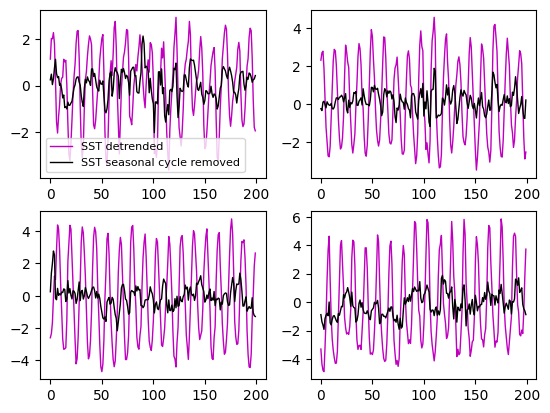

In [137]:
# Compute SST with cycle removed at testpoints:
sst_nocycle_testpoints = sst_nocycle.sel(lat=lat_testpoints, lon=lon_testpoints).compute()


# Plot before and after cycle removal, for first 200 timestamps:
n_ts = 200

fig2, axes2 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes2.flatten(), lat_testpoints, lon_testpoints):
    ax.plot(sst_detrend_testpoints.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'm-', linewidth=1, label='SST detrended')
    ax.plot(sst_nocycle_testpoints.isel(time=range(n_ts)).sel(lat=lat, lon=lon), 'k-', linewidth=1, label='SST seasonal cycle removed')
axes2[0,0].legend(fontsize=8)

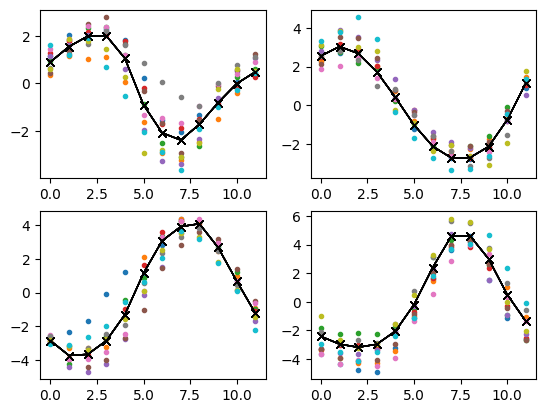

In [138]:
# Compute mean seasonal cycle at testpoints:
cycle_testpoints = seasonal_cycle.sel(lat=lat_testpoints, lon=lon_testpoints).compute()


fig3, axes3 = plt.subplots(2, 2)
for ax, lat, lon in zip(axes3.flatten(), lat_testpoints, lon_testpoints):
    for i in np.arange(1,11):
        ax.plot(sst_detrend_testpoints.isel(time=range(12*(i-1), 12*i)).sel(lat=lat, lon=lon), '.')
        ax.plot(cycle_testpoints.sel(lat=lat, lon=lon), 'kx-', linewidth=1)

## Variance map

A vmax of 1 is used because there are a few points over the globe with anomolously high variances.

In [139]:
sstvar = sst_nocycle.var(dim=['time'], skipna=True).compute()

/opt/coiled/env/lib/python3.11/site-packages/dask/array/numpy_compat.py:43: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


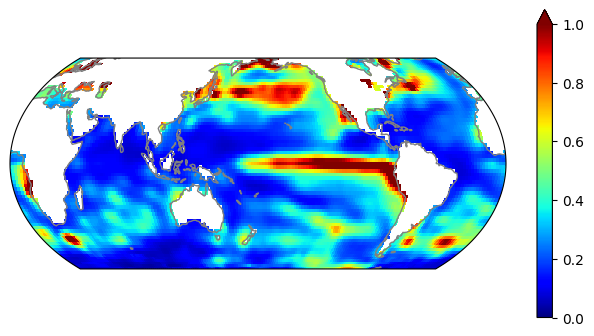

In [140]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    'transform': PlateCarree()
}

figvar = plt.figure(figsize=(8, 4))
axvar = plt.axes(projection=proj)
sstvar.plot(vmin=0, vmax=1, cmap='jet', **kwargs)
axvar.coastlines(color='.5')

In [141]:
sst_nocycle = sst_nocycle.where(sstvar < 2, drop=False)

## 3. EOF decomp

### 3.1 Using `eofs` package

Weight by latitude:

In [234]:
wgts = np.cos(np.deg2rad(sst_detrend_xa['lat']))**2

In [235]:
solver = Eof(
    sst_detrend, 
    weights = np.tile(wgts.values, (nlon, 1)).T
    )

/tmp/ipykernel_258/3491423890.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  solver = Eof(


In [252]:
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

In [253]:
varfrac

array([1.33961656e-01, 4.93072464e-02, 3.71169341e-02, ...,
       1.30001291e-32, 9.27160711e-33, 2.65562497e-33])

/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig4.colorbar(p, ax=ax)
/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig4.colorbar(p, ax=ax)
/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig4.colorbar(p, ax=ax)
/tmp/ipykernel_258/3180226628.py:23: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set

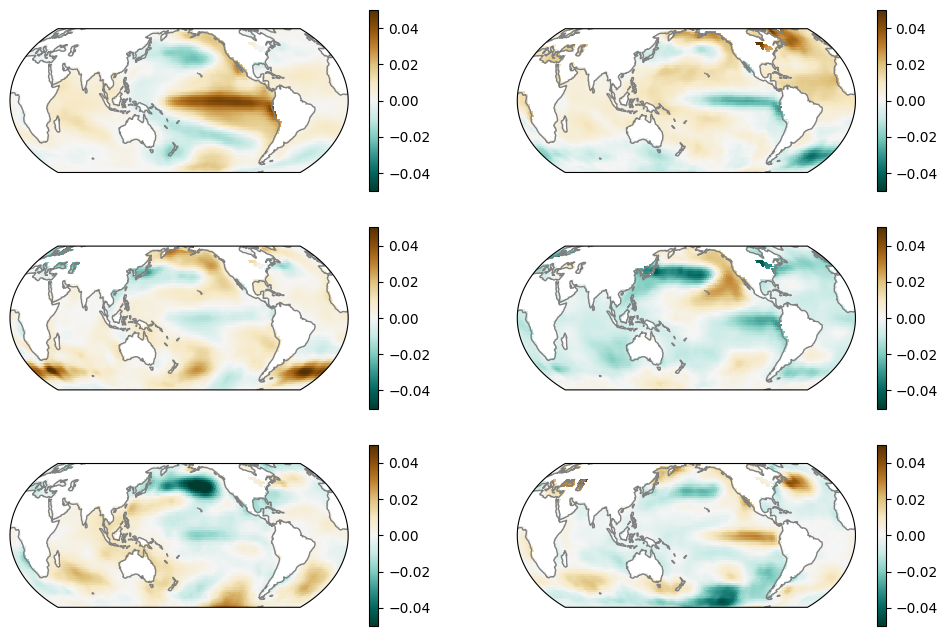

In [254]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    #'cmap' : 'RdBu', 'transform': PlateCarree()
    #'cmap' : 'RdYlBu_r', 'transform': PlateCarree()
    'cmap' : 'BrBG_r', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(6), axes4):
    p = ax.pcolor(
        sstdata['lon'], sstdata['lat'], eof1[i], 
        vmin=-0.05, vmax=0.05, 
        **kwargs
        )
    fig4.colorbar(p, ax=ax)

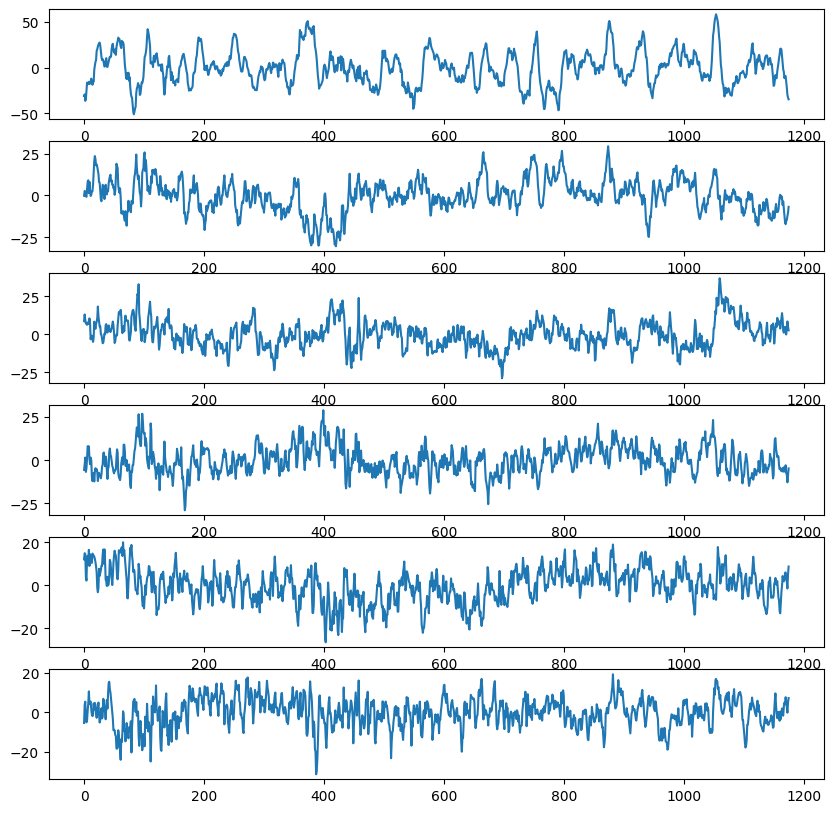

In [249]:
fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))

for i, ax in zip(range(6), axes5):
    ax.plot(pc1[:,i])
    #ax.set_ylim(-0.1, 0.1)

### 3.2 Using `xeofs` package

In [144]:
#wgts = np.cos(np.deg2rad(sst_nocycle['lat'])) # Weight by latitude
wgts = np.cos(np.deg2rad(sst_nocycle['lat']))**0.5 # Weight by latitude

In [145]:
%%time

model = xe.models.EOF(
    n_modes=6,
    use_weights=True,
    standardize=False
    )
model.fit(sst_nocycle, dim='time', weights=wgts)

CPU times: user 1min 14s, sys: 5.3 s, total: 1min 20s
Wall time: 1min 13s


In [146]:
%%time

expvar = model.explained_variance_ratio().compute()
expvar.values

CPU times: user 12.8 s, sys: 1.03 s, total: 13.8 s
Wall time: 12.2 s


array([0.13434482, 0.0363578 , 0.0231034 , 0.02295688, 0.02150905,
       0.01955743])

In [147]:
scores = model.scores().compute()
svals = model.singular_values().compute()
scores_raw = scores * svals

In [148]:
%%time

components = model.components().compute()

CPU times: user 11.9 s, sys: 778 ms, total: 12.7 s
Wall time: 11.3 s


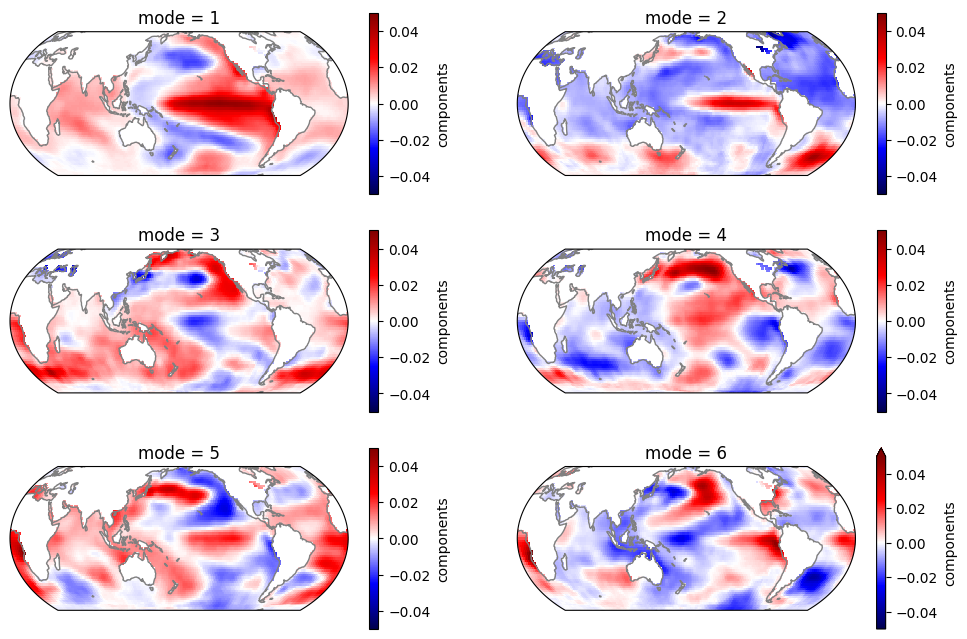

In [149]:
proj = EqualEarth(central_longitude=180)
kwargs = {
    #'cmap' : 'RdBu', 'transform': PlateCarree()
    'cmap' : 'seismic', 'transform': PlateCarree()
}

fig4 = plt.figure(figsize=(12, 8))

axes4 = []
for i in range(1, 7):
    axes4.append(plt.subplot(3, 2, i, projection=proj))

for ax in axes4:
    ax.coastlines(color='.5')
    
for i, ax in zip(range(1,7), axes4):
    components.sel(mode=i).plot(ax=ax, vmin=-0.05, vmax=0.05, **kwargs)
    #components.sel(mode=i).plot(ax=ax, vmin=-2, vmax=2, **kwargs)
    #components.sel(mode=i).plot(ax=ax, **kwargs)

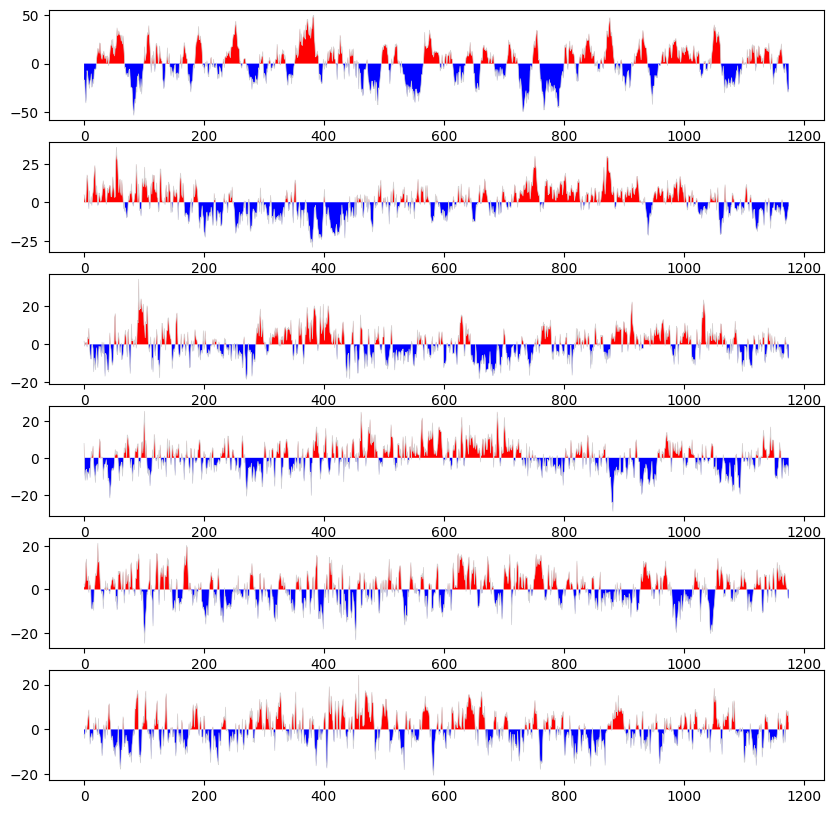

In [150]:
fig5, axes5 = plt.subplots(6, 1, figsize=(10,10))

x = range(len(scores['time']))
zeroline = np.zeros(len(x))

for i, ax in zip(range(1, 7), axes5):
    scores_raw_i = scores_raw.sel(mode=i).values
    pos_score = scores_raw_i > 0
    ax.fill_between(x, scores_raw_i, zeroline, where=pos_score, facecolor='red', interpolate=True)
    ax.fill_between(x, scores_raw_i, zeroline, where=~pos_score, facecolor='blue', interpolate=True)
    ax.plot(scores_raw_i, color='lightgrey', linewidth=0.5)
    #ax.set_ylim(-1, 1)